In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.ndimage

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx
from model_kit import mvls

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

The PSDs are calculated in a separate `.py` script (`mvls_fm_1in_glue.py`) to allow overnight calculations and passed through `mvls_cal_correct.ipynb` to properly calibrate the PSDs with the surface variance.

In [3]:
%%time
# 1-inch flats, unglued
file_dir = 'flat_mirrors/fixed_fits/'
psd_folder = 'zygo_data/flat_mirrors/mvls_psd/'
tot_fm = 1
tot_step = 4
flat_label = '1in'
psd_unit = (u.nm*u.m)**2

# get the psd side real quick
psd_base_name = 'lspsd_fm_{0}_n{1}_step{2}_glue'.format(flat_label, 1, 0)
psd_base_fits = fits.open(psd_folder+psd_base_name+'_cal.fits')[0]
psd_side = psd_base_fits.data.shape[0]
hdr = psd_base_fits.header
dk = hdr['delta_k']/u.m
kmin = hdr['kmin']*0.5/u.m # scale down kmin for rms checking because the resolution is bad for mvls
kmax = hdr['kmax']/u.m
del hdr['surf_var']

# full sets
psd_fm = np.zeros((tot_fm, tot_step, psd_side, psd_side))
avg_fm = np.zeros((tot_fm, psd_side, psd_side))
avg_set = np.zeros((psd_side, psd_side))
step_rms = np.zeros((tot_fm))
set_rms = np.zeros((tot_fm, tot_step))

for nfm in range(0, tot_fm):
    step_set = np.zeros((psd_side, psd_side)) # reset at start of new fm
    for nstep in range(0, tot_step):
        psd_name = 'lspsd_fm_{0}_n{1}_step{2}_glue_cal.fits'.format(flat_label, nfm+1, nstep)
        psd_fits = fits.open(psd_folder+psd_name)[0]
        psd_data = psd_fits.data
        # allocate the data
        psd_fm[nfm][nstep] = psd_data
        step_set = step_set + psd_data
        avg_set = avg_set + psd_data
        # save the rms value for final number comparison
        set_rms[nfm][nstep] = psd.do_psd_rms(psd_data=psd_data*psd_unit, 
                                             delta_k=dk, k_tgt_lim=(kmin,kmax)).value
    
    # calculate the step average
    avg_fm[nfm] = step_set/tot_step
    # calculate the rms of the step average
    sr = psd.do_psd_rms(psd_data=avg_fm[nfm]*psd_unit, delta_k=dk, k_tgt_lim=(kmin, kmax))
    step_rms[nfm] = sr.value
    print('n{0} avg rms: {1:.3f}'.format(nfm+1, sr))
    # write the file
    hdr['psd_rms'] = (sr.value, 
                      'RMS calculated from avg steps PSD [{0}]'.format(sr.unit))
    step_name = 'lspsd_fm_{0}_n{1}_avg_glue_cal'.format(flat_label, nfm+1)
    hdr['name'] = step_name
    fits.writeto(psd_folder+step_name+'.fits', avg_fm[nfm], hdr, overwrite=True)
    
# now calculate the total average
avg_set = avg_set/(tot_step*tot_fm)
avg_rms = psd.do_psd_rms(psd_data=avg_set*psd_unit, delta_k=dk, k_tgt_lim=(kmin, kmax))
print('fm_{0} avg rms: {1:.3f}'.format(flat_label, avg_rms))
hdr['psd_rms'] = (avg_rms.value, 'RMS calculated from all fm PSD [{0}]'.format(avg_rms.unit))
hdr['wavelen'] = (633e-9, 'Wavelength of measurement [m]') # needed for code
avg_name = 'lspsd_fm_{0}_avg_glue_cal'.format(flat_label)
hdr['name'] = avg_name
fits.writeto(psd_folder+avg_name+'.fits', avg_set, hdr, overwrite=True)

n1 avg rms: 18.104 nm
fm_1in avg rms: 18.104 nm
CPU times: user 33.2 ms, sys: 12.3 ms, total: 45.6 ms
Wall time: 52 ms


In [5]:
(np.mean(set_rms), np.std(set_rms))

(18.10159874076036, 0.27151150417821235)

In [6]:
np.std(set_rms)

0.27151150417821235

In [7]:
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  219                                                  
NAXIS2  =                  219                                                  
NAME    = 'lspsd_fm_1in_avg_glue_cal' / filename                                
PSD_UNIT= 'm2 nm2  '           / Units for PSD data                             
SURFUNIT= 'nm      '           / Units used for surface data                    
LATRES  = 9.12408759124087E-05 / Data spatial resolution [m]                    
DIAM_CA =   0.0199817518248175 / Physical diameter for clear aperture [m]       
DIAM_PIX=                  219 / Pixel diameter for data clear aperture         
DELTA_K =    50.04566210045665 / Spatial frequency lateral resolution [1/m]     
KMIN    =    50.045662100456

In [8]:
%%time
# calculate the radial psds
# I know I could have done it with the original loop, but that was already a mess to write.
# this is fast, so it's fine to keep redoing.
for nfm in range(0, tot_fm):
    for nstep in range(0, tot_step):
        kr, pr = psd.do_psd_radial(psd_data=psd_fm[nfm][nstep]*psd_unit,
                                   delta_k=dk, kmin=kmin)
        if nfm==0 and nstep==0:
            kr_fm = np.zeros((tot_fm, tot_step, len(kr)))
            pr_fm = np.zeros((tot_fm, tot_step, len(pr)))
        kr_fm[nfm][nstep] = np.asarray(kr)
        pr_fm[nfm][nstep] = np.asarray(pr)
    # now look at the set radial
    if nfm==0:
        kr_fm_avg = np.zeros((tot_fm, len(kr)))
        pr_fm_avg = np.zeros((tot_fm, len(pr)))
    kr, pr = psd.do_psd_radial(psd_data=avg_fm[nfm]*psd_unit, delta_k=dk, kmin=kmin)
    kr_fm_avg[nfm] = np.asarray(kr)
    pr_fm_avg[nfm] = np.asarray(pr)
# now look at the full average
kr_avg_set, pr_avg_set = psd.do_psd_radial(psd_data=avg_set*psd_unit, delta_k=dk, kmin=kmin)

CPU times: user 272 ms, sys: 0 ns, total: 272 ms
Wall time: 279 ms


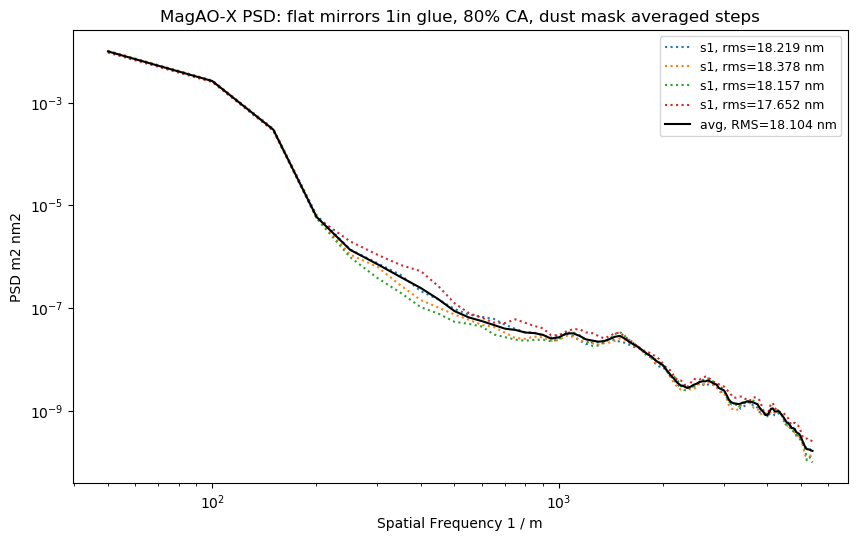

In [12]:
plt.figure(figsize=[10,6],dpi=100, facecolor='white')
for nstep in range(0, tot_step):
    plt.loglog(kr_fm[0][nstep], pr_fm[0][nstep], ':',
               label='s{0}, rms={1:.3f} nm'.format(nfm+1, set_rms[0][nstep]))
plt.loglog(kr_avg_set, pr_avg_set, 'k', label='avg, RMS={0:.3f}'.format(avg_rms))
plt.xlabel('Spatial Frequency {0}'.format(dk.unit))
plt.ylabel('PSD {0}'.format(psd_unit))
plt.title('MagAO-X PSD: flat mirrors {0} glue, 80% CA, dust mask averaged steps'.format(flat_label))
plt.legend(prop={'size':9})#,loc='center left', bbox_to_anchor=(1, 0.5))